In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#MA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pmd
from statsmodels.tsa.seasonal import seasonal_decompose


Get data, cleanning it, indexing with dates aggregating sentiment per day and saving it to another dataframe.

In [2]:
data = pd.read_csv('ProjectPH.csv', usecols = [i for i in range(1,7)], index_col=0, parse_dates= True)
data['created'] = pd.to_datetime(data.index)


## ['[effacé]', '[supprimé]', 'Title', 'title', 'Title.']
to_delete = np.array(data.selftext.value_counts().index[0:5])
posts_to_delete_filter = data.selftext.isin(to_delete)
print(f'#deleted: {np.sum(posts_to_delete_filter)}, #rows:{data.shape[0]}, %deleted: {np.sum(posts_to_delete_filter)/data.shape[0]}')
data = data[~posts_to_delete_filter]

# date_time_format = '%Y-%m-%d %H:%M:%S'

## create df per day
dates = np.sort(np.unique(data.created.dt.date))
mean_per_day = data.groupby(data.index.date).mean()

data_per_day = pd.DataFrame({"day": dates, "polarity": mean_per_day.sentiment_polarity, "subjectivity": mean_per_day.sentiment_subjectivity})
data_per_day.index, data_per_day.day = pd.DatetimeIndex(data_per_day.index), pd.to_datetime(data_per_day.index)
data_per_day.head()

#deleted: 19380, #rows:51036, %deleted: 0.3797319539148836


,day,polarity,subjectivity
2016-08-15,2016-08-15,-0.035417,0.116667
2016-08-16,2016-08-16,0.066855,0.168214
2016-08-17,2016-08-17,0.059619,0.191298
2016-08-18,2016-08-18,0.030986,0.300668
2016-08-19,2016-08-19,0.079680,0.318844


Computing mean polarity per day per month, that could be used as prediction or trend for 2022.

In [3]:
month_day_vector = pd.to_datetime([f"2020-{str(month)}-{str(day)}" for day, month in zip(data.index.day, data.index.month)])
month_day_uniques = month_day_vector.unique().sort_values(ascending=1)

polarity_mean_per_day = []
subjectivity_mean_per_day = []
for month_day in month_day_uniques:
    filter_same_month_and_day = np.logical_and(data.index.day == month_day.day, data.index.month ==  month_day.month)
    polarity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_polarity)/np.sum(filter_same_month_and_day))
    subjectivity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_subjectivity)/np.sum(filter_same_month_and_day))

# sentiment_per_month = data.sentiment_polarity.groupby(data.index.month).mean()

Plotsss

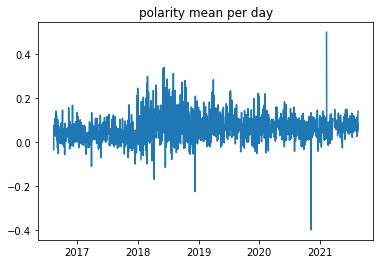

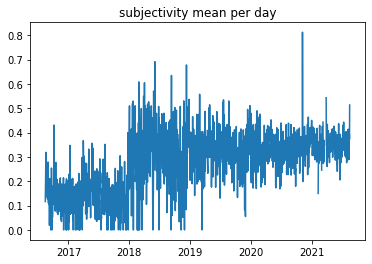

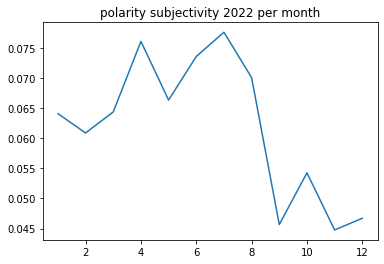

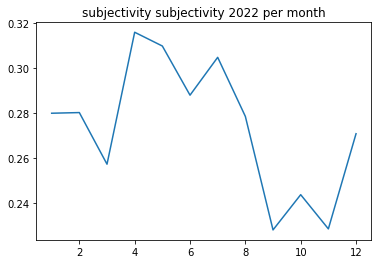

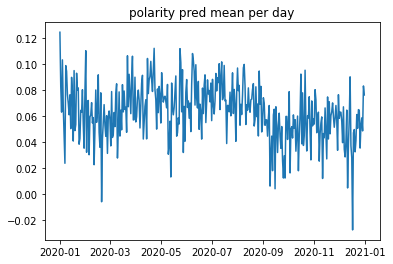

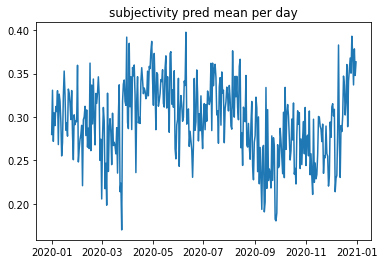

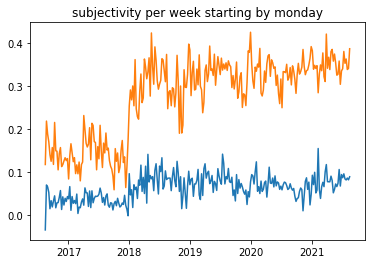

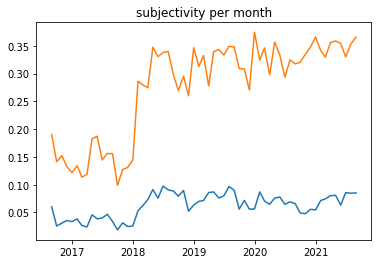

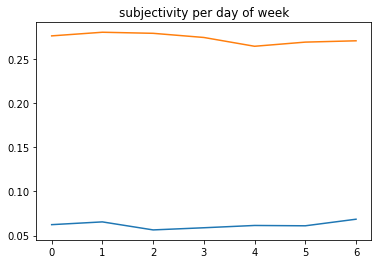

In [4]:
def plot(x, y, title, show = True):
    plt.plot(x, y)
    plt.title(title)
    if show: plt.show()

def plot_df(df, title_to_add_after_col_name, y_col_names = [], show_every = True, x_col = "index"):
    y_col_names = df.columns if y_col_names == [] else y_col_names
    for col_name in y_col_names:
        x = df.index if x_col == "index" else df[x_col]
        plot(x, df[col_name], col_name + " " + title_to_add_after_col_name, show_every)
    if not show_every: plt.show()

plot_df(data_per_day.groupby(pd.Grouper(key = "day", freq="D")).mean(), "mean per day" )

plot_df(data_per_day.groupby(data_per_day.index.month).mean(), "subjectivity 2022 per month")

plot(month_day_uniques, polarity_mean_per_day, "polarity pred mean per day")
plot(month_day_uniques, subjectivity_mean_per_day, "subjectivity pred mean per day")
plot_df(data_per_day.groupby(pd.Grouper(key = "day", freq="W-MON")).mean(), "per week starting by monday", show_every= False)
plot_df(data_per_day.groupby(pd.Grouper(key = "day", freq="M")).mean(), "per month", show_every= False)

plot_df(data_per_day.groupby(data_per_day.index.weekday).mean(), 'per day of week', show_every= False)

Working on data_per_week

In [5]:
data_per_week = data_per_day.groupby(pd.Grouper(key = "day", freq="W-MON")).mean()

In [6]:
print(adfuller(data_per_week.polarity)[:2])
print(adfuller(data_per_week.polarity.diff()[1:]))

(-1.8524671285603975, 0.3547415447595331)
(-6.545781669136731, 9.10716633358628e-09, 11, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, -1143.1751286542403)


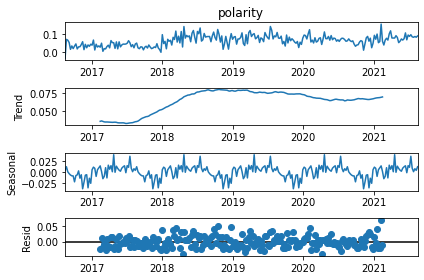

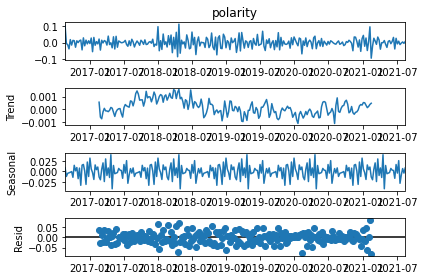

In [7]:
seasonal_decompose(data_per_week.polarity, model='additive').plot()
plt.show()
seasonal_decompose(data_per_week.polarity.diff()[1:], model='additive').plot()
plt.show()

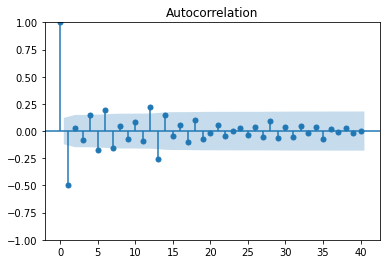

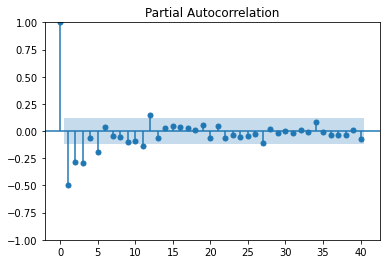

In [8]:
plot_acf(data_per_week.polarity.diff()[1:], lags=40)
plt.show()
plot_pacf(data_per_week.polarity.diff()[1:], lags=40, method="ywm")
plt.show()

In [9]:
res = pmd.auto_arima(data_per_week.polarity, start_p=1, start_q=1, test="adf", trace=True)
res.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1211.497, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1069.666, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1145.613, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1212.802, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1071.605, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1211.692, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1214.952, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1213.964, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1212.719, Time=0.57 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1208.928, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1209.798, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1209.218, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1216.109, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1213.043, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 612.054
Date:                Wed, 08 Dec 2021   AIC                          -1216.109
Time:                        19:22:49   BIC                          -1201.851
Sample:                             0   HQIC                         -1210.378
                                - 262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9048      0.108     -8.342      0.000      -1.117      -0.692
ma.L1          0.0324      0.138      0.235      0.814      -0.238       0.303
ma.L2         -0.6910      0.122     -5.643      0.000      -0.931      -0.451
sigma2         0.0005    3.7e-05     14.459      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                29.70
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.55
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
ARIMA_001 = ARIMA(data_per_week.polarity, order= (0,0,1)).fit()
ARIMA_011 = ARIMA(data_per_week.polarity, order= (0,1,1)).fit()
ARIMA_112 = ARIMA(data_per_week.polarity, order= (1,1,2)).fit()
ARIMA_213 = ARIMA(data_per_week.polarity, order= (2,1,3)).fit()

<AxesSubplot:xlabel='day'>

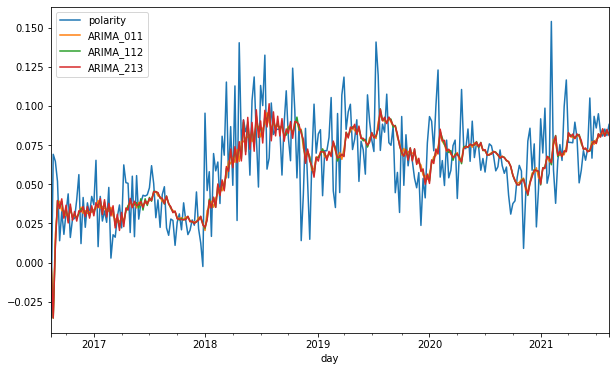

In [11]:
start, end = data_per_week.index[0], data_per_week.index[-1]

data_per_week['ARIMA_011'] = ARIMA_011.predict(start, end)
data_per_week['ARIMA_112'] = ARIMA_112.predict(start, end)
data_per_week['ARIMA_213'] = ARIMA_213.predict(start, end)

data_per_week[["polarity", "ARIMA_011", "ARIMA_112", "ARIMA_213"]].plot(figsize=(10, 6))

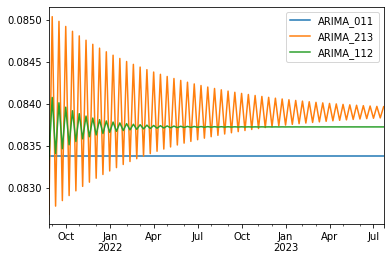

In [12]:
pred_start, pred_end = len(data_per_week) + 1,len(data_per_week)+100
preds = pd.DataFrame(ARIMA_011.predict(pred_start, pred_end))
preds.columns = ['ARIMA_011']
preds['ARIMA_213'] = ARIMA_213.predict(pred_start, pred_end)
preds['ARIMA_112'] = ARIMA_112.predict(pred_start, pred_end)
preds['ARIMA_112'] = ARIMA_112.predict(pred_start, pred_end)
preds.plot()
plt.show()


Working on data_per_day

In [13]:
if "day" in data_per_day.columns:
    data_per_day = data_per_day.drop(columns=["day"])
if "subjectivity" in data_per_day.columns:
    data_per_day = data_per_day.drop(columns=["subjectivity"])

(-4.026452664985581, 0.0012781586036489084)


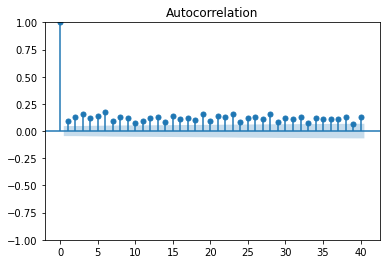

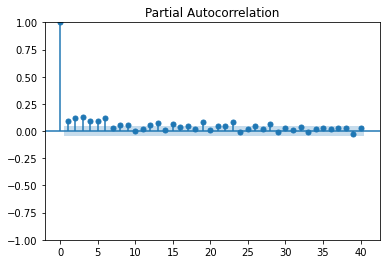

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5429.504, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5249.526, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5264.624, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5261.422, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3824.008, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5399.760, Time=1.73 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5432.631, Time=1.87 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5278.400, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5427.061, Time=2.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5394.594, Time=2.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-5298.265, Time=1.25 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-5425.826, Time=2.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5431.876, Time=1.09 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 15.468 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1806
Model:               SARIMAX(1, 0, 2)   Log Likelihood                2721.316
Date:                Wed, 08 Dec 2021   AIC                          -5432.631
Time:                        19:23:07   BIC                          -5405.137
Sample:                             0   HQIC                         -5422.484
                               - 1806                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.906      0.057   -1.33e-05       0.001
ar.L1          0.9922      0.004    257.621      0.000       0.985       1.000
ma.L1         -0.9878      0.022    -45.540      0.000      -1.030      -0.945
ma.L2          0.0350      0.021      1.668      0.095      -0.006       0.076
sigma2         0.0028   4.24e-05     66.161      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              4346.35
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.40
Prob(H) (two-sided):                  0.30   Kurtosis:                        10.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
print(adfuller(data_per_day.polarity)[:2])
plot_acf(data_per_day.polarity, lags=40)
plt.show()
plot_pacf(data_per_day.polarity, lags=40, method = "ywm")
plt.show()

res = pmd.auto_arima(data_per_day.polarity, start_p=1, start_q=1, test="adf", trace=True)
res.summary()

In [15]:
data_per_day = data_per_day.asfreq("D")

In [16]:
SARIMAX_102 = SARIMAX(data_per_day.polarity, order= (1,0,2)).fit()
SARIMAX_203 = SARIMAX(data_per_day.polarity, order= (2,0,3)).fit()
ARIMA_203 = ARIMA(data_per_day.polarity, order= (2,0,3)).fit()
ARIMA_000 = ARIMA(data_per_day.polarity, order= (0,0,0)).fit()
ARIMA_003 = ARIMA(data_per_day.polarity, order= (0,0,3)).fit()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[]

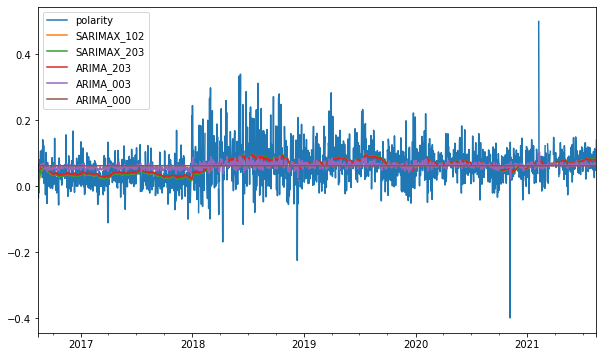

In [23]:
start, end = data_per_day.index[0], data_per_day.index[-1]

data_per_day['SARIMAX_102'] = SARIMAX_102.predict(start, end)
data_per_day['SARIMAX_203'] = SARIMAX_203.predict(start, end)
data_per_day['ARIMA_203'] = ARIMA_203.predict(start, end)
data_per_day['ARIMA_000'] = ARIMA_000.predict(start, end)
data_per_day['ARIMA_003'] = ARIMA_003.predict(start, end)


data_per_day.plot(figsize=(10, 6))
plt.plot()

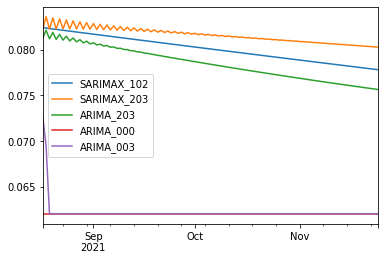

In [24]:
pred_start, pred_end = len(data_per_day) + 1,len(data_per_day)+100
preds = pd.DataFrame(SARIMAX_102.predict(pred_start, pred_end))
preds.columns = ['SARIMAX_102']
preds['SARIMAX_203'] = SARIMAX_203.predict(pred_start, pred_end)
preds['ARIMA_203'] = ARIMA_203.predict(pred_start, pred_end)
preds['ARIMA_000'] = ARIMA_000.predict(pred_start, pred_end)
preds['ARIMA_003'] = ARIMA_003.predict(pred_start, pred_end)
preds.plot()
plt.show()